# Solution

### Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from solvers import solver
from tabulate import tabulate
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from typing import Callable, List, Tuple, TypeVar


## Implementation

[*Write code to be able to run three methods you have chosen for arbitrary initial conditions ($x(t=0), y(t=0)$), time step ($\mathrm{d}t$), model parameters ($\alpha, \beta, \gamma, \delta$) and functions $f$ and $g$. [50 words]*]

### Model parameters

In [2]:
def rhs(t, u):
    alpha = 1
    beta = 1
    gamma = 1
    delta = 1
    f = lambda t: -np.sin(t) - np.cos(t)**2 - np.cos(t)
    g = lambda t: np.sin(t) + np.cos(t)**2 - np.cos(t)

    dx_dt = alpha * u[0] - beta * u[0] * u[1] + f(t)
    dy_dt = delta * u[0] * u[1] - gamma * u[1] + g(t)

    return np.array([dx_dt, dy_dt])

def rhs_B(t, u):
    alpha_B = 2/3
    beta_B = 4/3
    gamma_B = 1
    delta_B = 1
    f_B = lambda t: 0
    g_B = lambda t: 0

    dx_dt = alpha_B * u[0] - beta_B * u[0] * u[1] + f_B(t)
    dy_dt = delta_B * u[0] * u[1] - gamma_B * u[1] + g_B(t)

    return np.array([dx_dt, dy_dt])

### Implementing a new method

This implementation is entirely based off solvers.py - I define my function parameters in the same way, and return the same datatypes for ease of use.


In [3]:
y_type = TypeVar("y_type", np.ndarray, np.double)

def midpoint_method(
    rhs: Callable[[np.double, y_type], y_type],
    y0: y_type,
    t0: np.double,
    dt: np.double,
    T: np.double,
) -> Tuple[List[np.double], List[y_type]]:

    # initialise starting values
    t_out = [t0]
    y_out = [y0]

    # count steps
    timesteps = int(T / dt)

    # time loop
    for step in range(timesteps):
        # use midpoint method
        k1 = rhs(t_out[-1], y_out[-1])  # f( t(i), y(i) )
        k2 = rhs(t_out[-1] + dt, y_out[-1] + dt * k1)  # f( t(i) + dt, y(i) + dt(f( t(i),y(i) )) ) -> k
        y_update = 0.5 * (k1 + k2) * dt # half it and times it by dt once more fully

        y_new = y_out[-1] + y_update # add this value to current y
        t_new = t_out[-1] + dt # increment t by dt

        t_out.append(t_new) #add these values to top of list
        y_out.append(y_new)

    return t_out, y_out


### Running the methods with time steps and parameters

In [4]:
def run_test_case(u0, T, time_steps, methods, rhs_function):
    total_times = {method: [] for method in methods}
    line_positions = np.arange(len(time_steps))
    # run for each interval size, and each method
    for dt_factor in time_steps:
        dt = T / dt_factor

        for method in methods:
            start_time = time.time()
            if method == "Midpoint":
                t, sol = midpoint_method(rhs_function, u0, 0, dt, T)
            else:
                t, sol = solver(rhs_function, u0, 0, dt, T, method)
            end_time = time.time()

            total_time = end_time - start_time
            total_times[method].append(total_time)

    return total_times

time_steps = [100, 200, 400, 800, 1600]
methods = ["Ralston", "Runge-Kutta", "Midpoint"]

# running test cases A and B, and storing the time taken for later results
T_A = 2.5 * np.pi
u0_A = np.array([2.0, 0.0]) # x0 = 2, y0 = 0
total_times_A = run_test_case(u0_A, T_A, time_steps, methods, rhs) 

T_B = 30
u0_B = np.array([0.9, 0.9])  # x0 = 0.9, y0 = 0.9
total_times_B = run_test_case(u0_B, T_B, time_steps, methods, rhs_B)


## Results

[*Simulate and show results for each of the test cases suggested by your boss for a range of time steps until a final time $T$.
For test case A, you should use $T = 2.5\pi$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
For test case B, you should use $T = 30$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
You should demonstrate how solutions look for each method, and the accuracy and efficiency of each approach. [50 words]*]



### Tables of values
*Warning - large datasets below*

Tables of each value of X at each multiple of dt for the solution, for each method and step size.

In [14]:
#using tabulate to format bulk data
#case A
for method in methods:
    print(f"\nResults for {method} (Test Case A):\n")
    headers_A = ['Time/2.5π  (s/2.5π)', '(Prey)', '(Predator)']

    for dt_factor, times in zip(time_steps, total_times_A[method]):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")
        if method == "Midpoint":
            t_ref, sol_ref = midpoint_method(rhs, u0_A, 0, T_A / dt_factor, T_A)
        else:
            t_ref, sol_ref = solver(rhs, u0_A, 0, T_A / dt_factor, T_A, method)
        sol_ref = np.array(sol_ref)

        formatted_t = ["({}/{})".format(int(ti / (T_A / dt_factor)), int(2.5 * np.pi / (T_A / dt_factor))) for ti in t_ref]
        table_data_A = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))
        table_A = tabulate(table_data_A, headers=headers_A, tablefmt='pretty')
        print(table_A)
#case B
for method in methods:
    print(f"\nResults for {method} (Test Case B):\n")
    headers_B = ['Time/30  (s/30)', '(Prey)', '(Predator)'] 

    for count, (dt_factor, times) in enumerate(zip(time_steps, total_times_B[method])):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")

        if method == "Midpoint":
            t_ref, sol_ref = midpoint_method(rhs_B, u0_B, 0, T_B / dt_factor, T_B)
        else:
            t_ref, sol_ref = solver(rhs_B, u0_B, 0, T_B / dt_factor, T_B, method)
        sol_ref = np.array(sol_ref)

        formatted_t = ["({}/{})".format(i, dt_factor) for i in range(len(t_ref))]
        table_data_B = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        table_B = tabulate(table_data_B, headers=headers_B, tablefmt='pretty')
        print(table_B)


Results for Ralston (Test Case A):

dt = T/100, Total Time = 0.002503 s
+---------------------+-----------------------+----------------------+
| Time/2.5π  (s/2.5π) |        (Prey)         |      (Predator)      |
+---------------------+-----------------------+----------------------+
|       (0/100)       |          2.0          |         0.0          |
|       (1/100)       |   1.997159228272417   | 0.003002225860596471 |
|       (2/100)       |  1.9882030959865624   | 0.012145893936654712 |
|       (3/100)       |  1.9731886546450101   | 0.027375879034991522 |
|       (4/100)       |  1.9522096014108932   | 0.048600231282026465 |
|       (5/100)       |  1.9253954767828962   | 0.07569084225009723  |
|       (6/100)       |  1.8929106463611969   | 0.10848430429470708  |
|       (7/100)       |  1.8549530961625214   | 0.14678293889221908  |
|       (8/100)       |  1.8117530766957042   | 0.19035596770928584  |
|       (9/100)       |  1.7635716341303191   |  0.2389408009368964  |
|   

### Visualisations of the solutions
Solution tables for x and y at each point in time, using the smallest interval size.

All methods are shown, although almost entirely overlap as difference in accuracy is negligible.

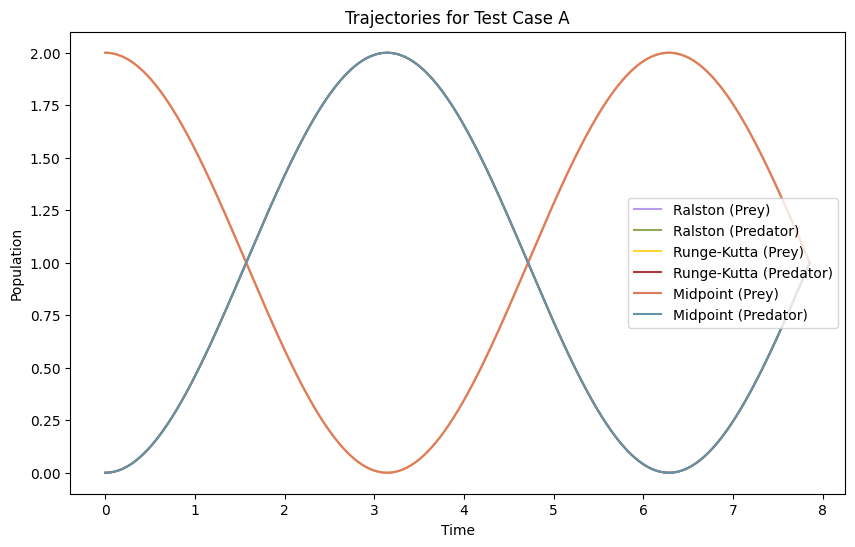

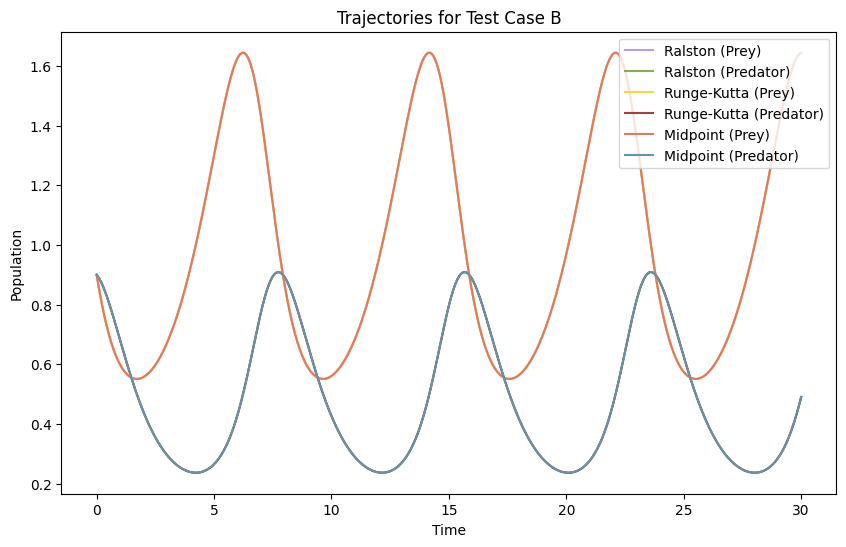

In [6]:

plt.figure(figsize=(10, 6))
colors=['#B79CED','#FFD639','#E07A5F']
colors_2=['#90A959','#A63D40','#6494AA']
for i, method in enumerate(methods):
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (Prey)",color=colors[i])
    plt.plot(t, sol[:, 1], label=f"{method} (Predator)",color=colors_2[i])

plt.title("Trajectories for Test Case A")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i, method in enumerate(methods):
    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (Prey)",color=colors[i])
    plt.plot(t, sol[:, 1], label=f"{method} (Predator)",color=colors_2[i])

plt.title("Trajectories for Test Case B")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

### Drawing Phase Spaces

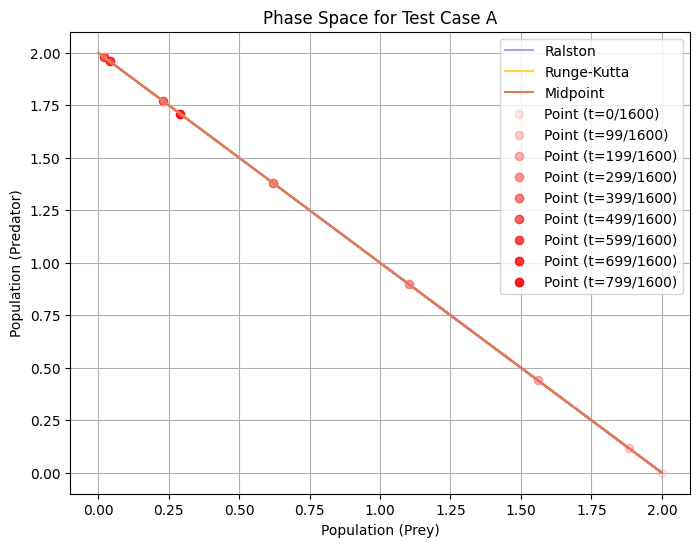

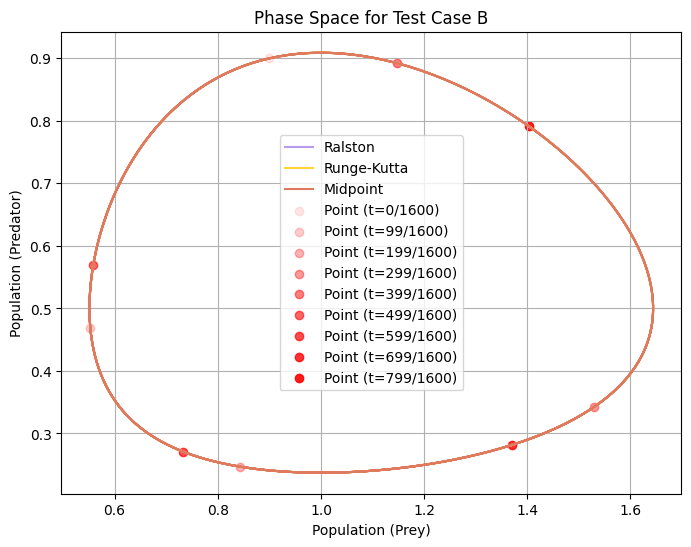

In [7]:
def plot_phase_plane_with_initial_points(sol, methods, case, opacity_start=0.1, opacity_increment=0.1):
    plt.figure(figsize=(8, 6))
    
    for method, color in zip(methods, colors):
        method_index = methods.index(method)
        plt.plot(sol[method_index][:, 0], sol[method_index][:, 1], label=f"{method}", color=color)

    initial_points = sol[0][:, :] 
    for i in [0, 99, 199, 299, 399, 499, 599, 699, 799]: # some evenly spaced points to plot
        plt.scatter(initial_points[i, 0], initial_points[i, 1], marker='o', color='red', label=f"Point (t={i}/1600)", alpha=opacity_start)
        opacity_start += opacity_increment

    plt.title(f"Phase Space for Test Case {case}")
    plt.xlabel("Population (Prey)")
    plt.ylabel("Population (Predator)")
    plt.legend()
    plt.grid(True)
    plt.show()

sol_all_methods_A = []
sol_all_methods_B = []

for method in methods:
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol_all_methods_A.append(np.array(sol))

for method in methods:
    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol_all_methods_B.append(np.array(sol))

plot_phase_plane_with_initial_points(sol_all_methods_A, methods, "A")
plot_phase_plane_with_initial_points(sol_all_methods_B, methods, "B")


I have plotted some intervals of T on the phase space, as smaller intervals between points indicate regions where the xy values change less over time - for example the turning points of each population.

### Calculation Time

Charts to display the efficiency of each method based on how long execution takes.

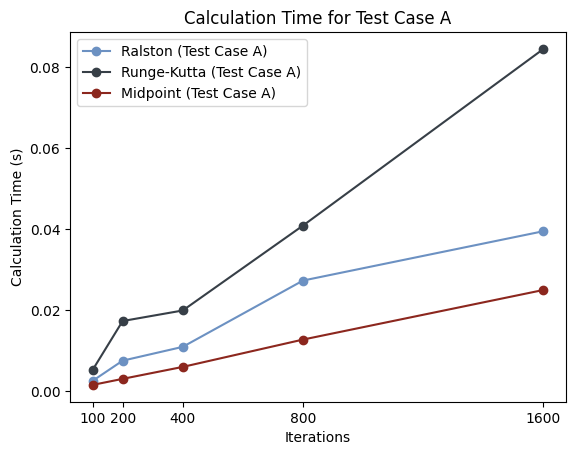

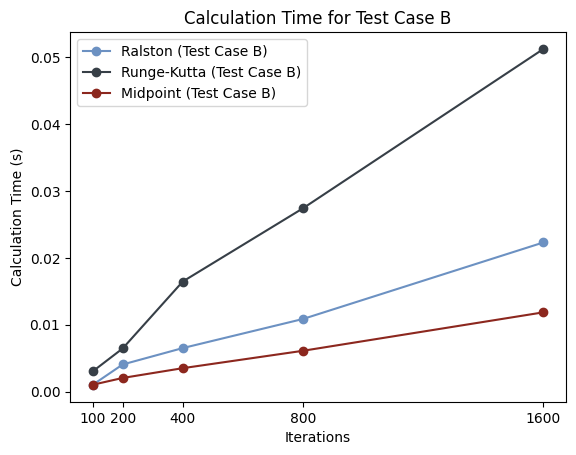

In [15]:
plt.figure()
colors=['#6C91C2','#373F47','#8C271E']
for i, method in enumerate(methods):
    plt.plot(time_steps, total_times_A[method], marker='o', label=f"{method} (Test Case A)", color=colors[i])

plt.title("Calculation Time for Test Case A")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()

plt.figure()
for i, method in enumerate(methods):
    plt.plot(time_steps, total_times_B[method], marker='o', label=f"{method} (Test Case B)", color=colors[i])

plt.title("Calculation Time for Test Case B")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()


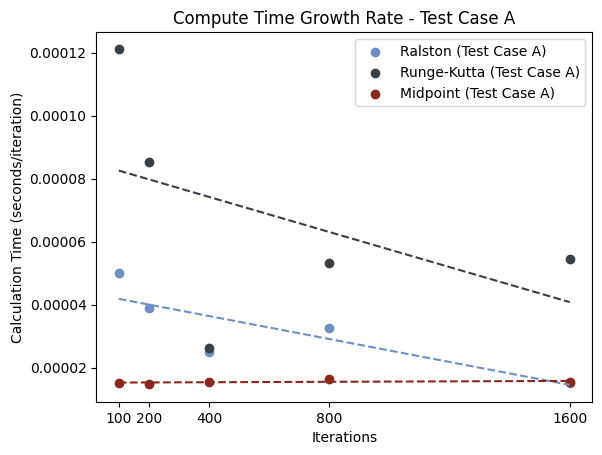

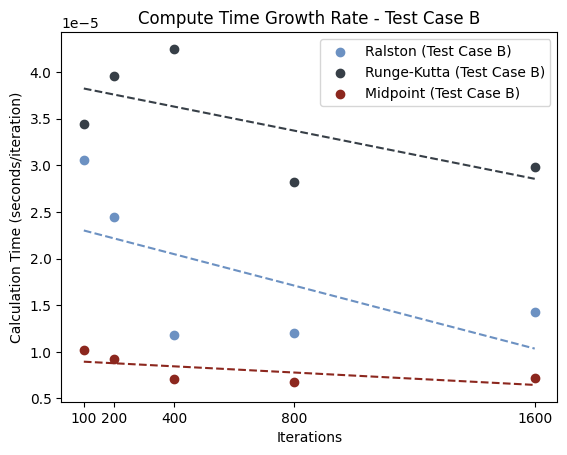

In [17]:
def calculate_derivative(time_steps, total_times):
    derivatives = []
    for method in methods:
        derivative = np.gradient(total_times[method], time_steps)
        derivatives.append(derivative)
    return derivatives

def fit_line(x, y):
    coefficients = np.polyfit(x, y, 1)
    return coefficients

#case A
derivatives_A = calculate_derivative(time_steps, total_times_A)
plt.figure()
for i, method in enumerate(methods):
    plt.scatter(time_steps, derivatives_A[i], label=f"{method} (Test Case A)", color=colors[i])
    coefficients = fit_line(time_steps, derivatives_A[i])
    line = np.polyval(coefficients, time_steps) # making line of best fit
    plt.plot(time_steps, line, linestyle='--', color=colors[i])
plt.title("Compute Time Growth Rate - Test Case A")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (seconds/iteration)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()

#case B
derivatives_B = calculate_derivative(time_steps, total_times_B)
plt.figure()
for i, method in enumerate(methods):
    plt.scatter(time_steps, derivatives_B[i], label=f"{method} (Test Case B)", color=colors[i])
    coefficients = fit_line(time_steps, derivatives_B[i])
    line = np.polyval(coefficients, time_steps)
    plt.plot(time_steps, line, linestyle='--', color=colors[i])
plt.title("Compute Time Growth Rate - Test Case B")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (seconds/iteration)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()


### Solution Inaccuracy - Test Case A
We can compare test case A to the exact solution to visualise the accuracy of each method.

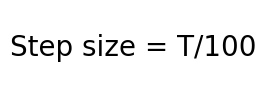

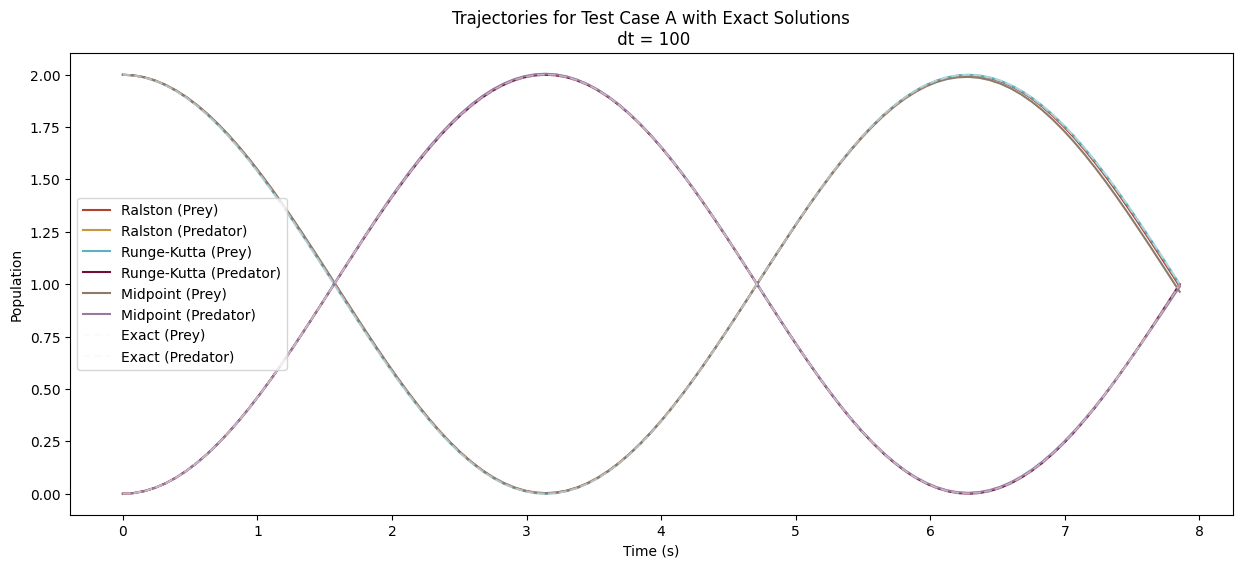

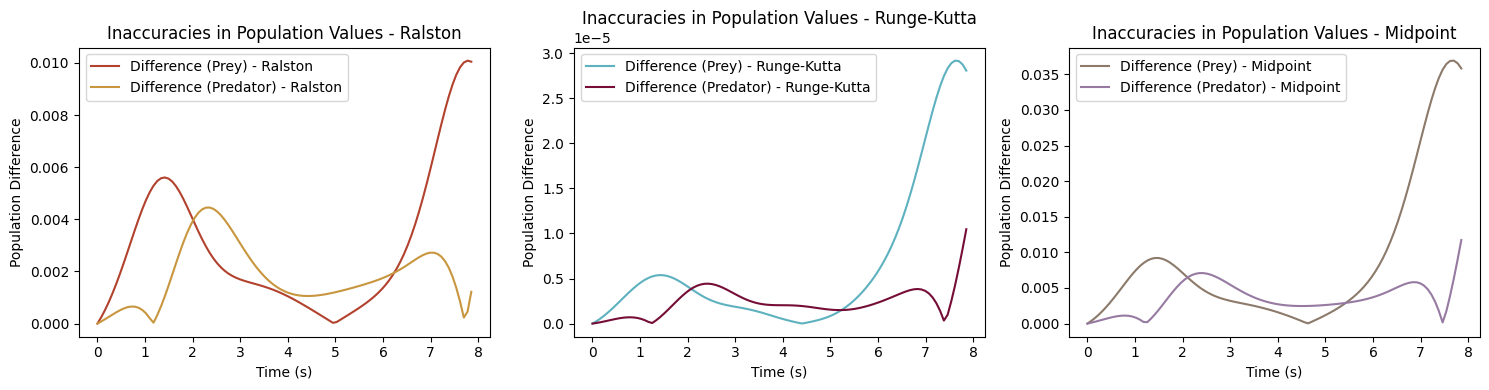

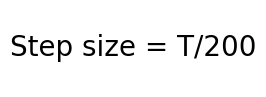

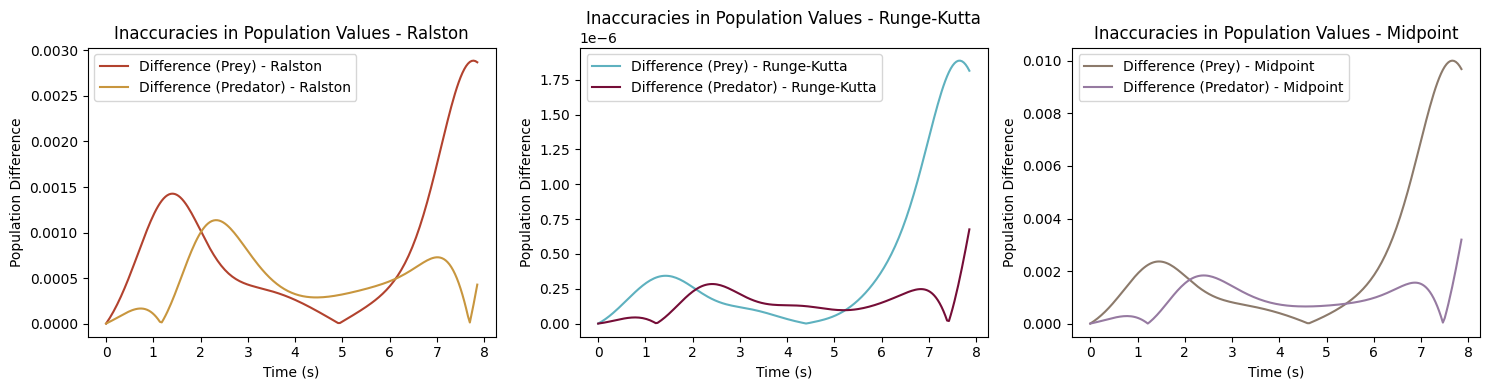

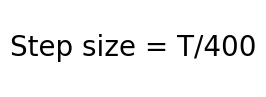

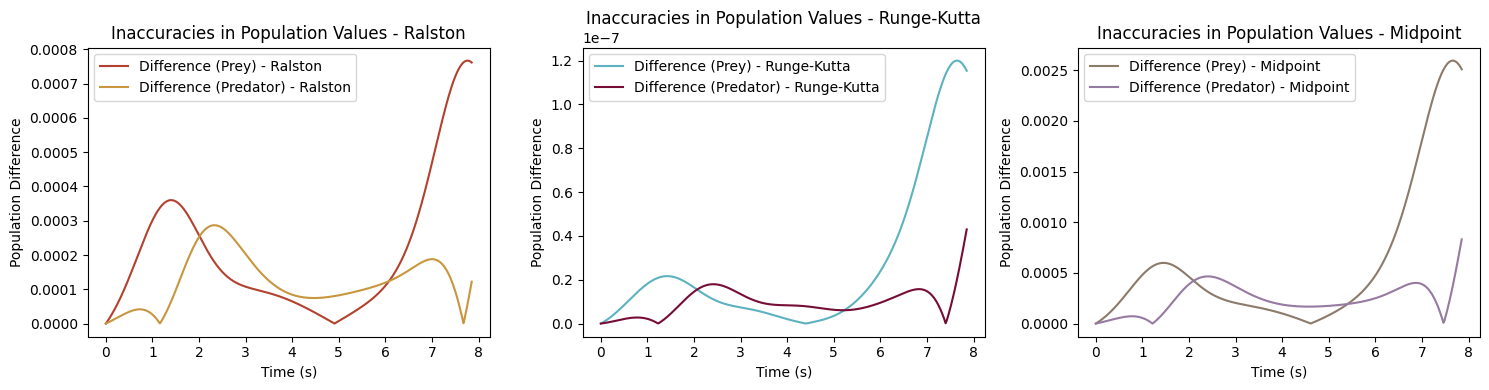

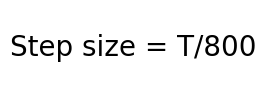

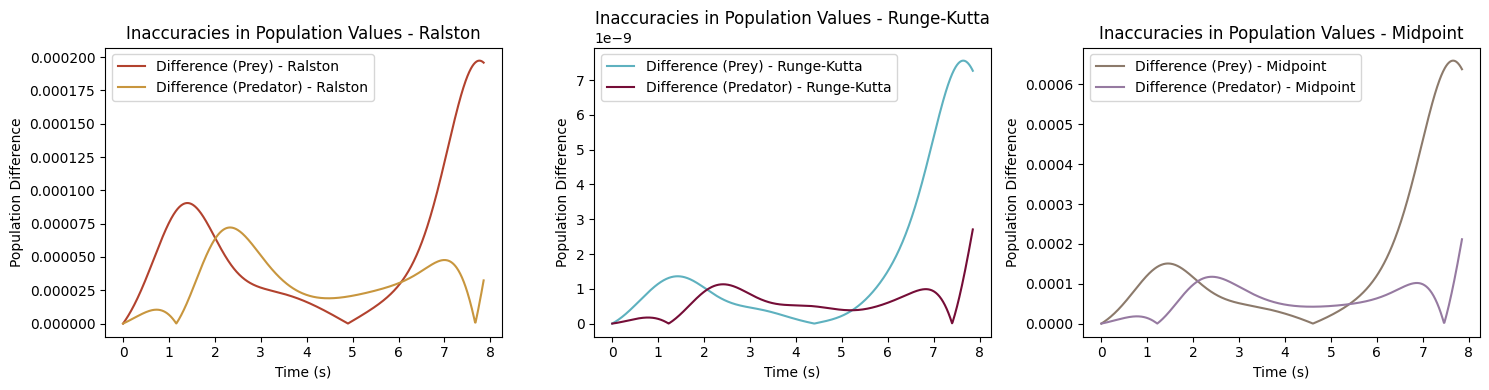

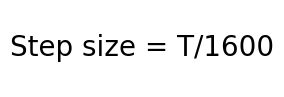

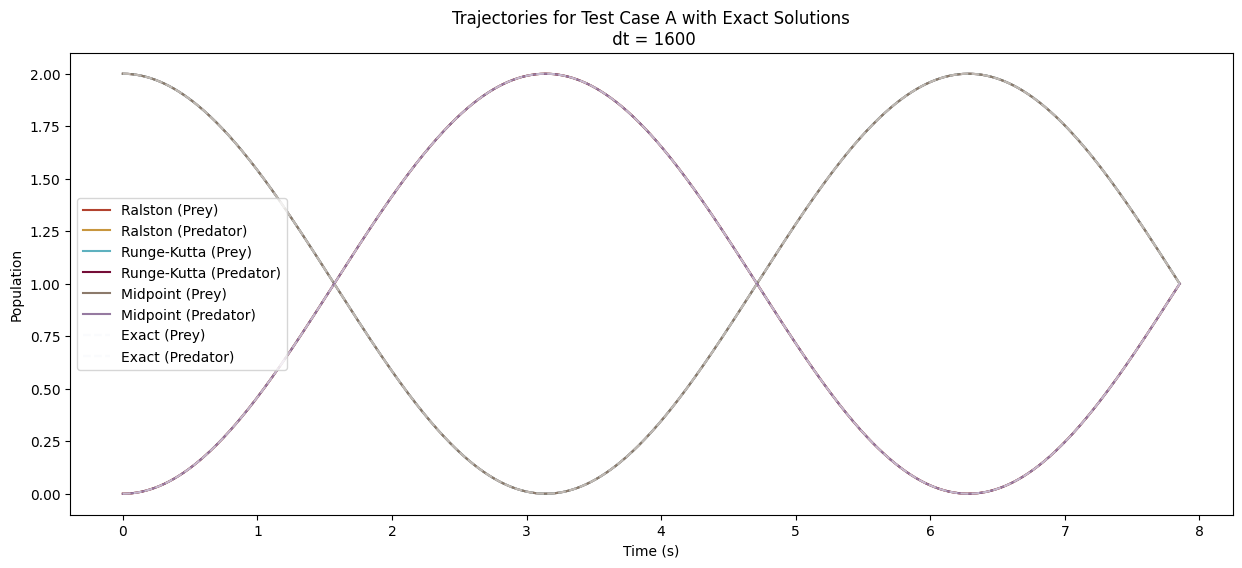

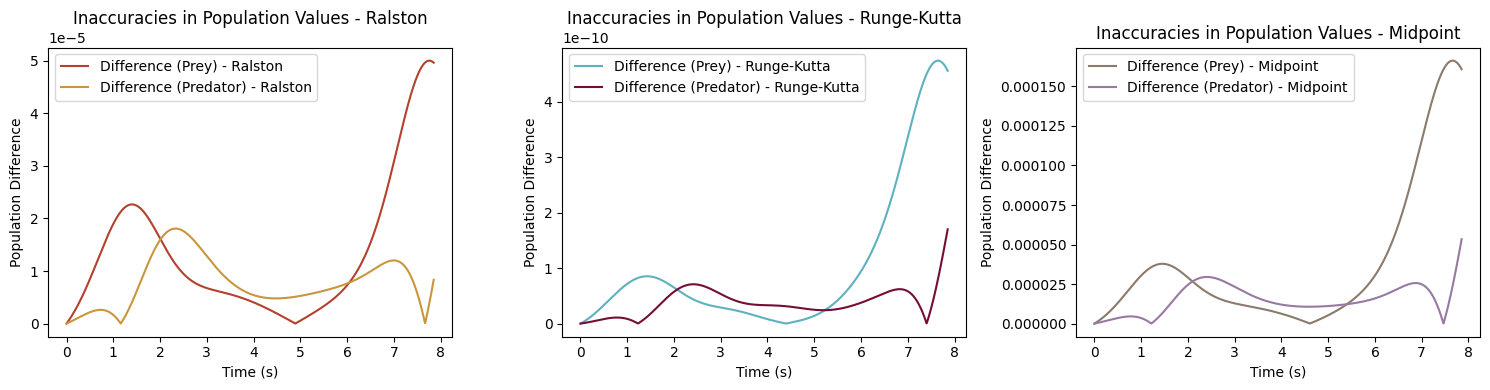

In [10]:
hex_colors = ['#042A2B', '#B2422E', '#5EB1BF','#8C7A6B','#967AA1', '#750D37', '#C8963E']
for steps in time_steps:

    plt.figure(figsize=(3, 1))
    plt.axis('off')
    section_text = "Step size = T/" + str(steps)
    plt.text(0.5, 0.5, section_text, horizontalalignment='center', verticalalignment='center', fontsize=20)
    plt.show()

    if steps == 100 or steps == 1600:
        plt.figure(figsize=(15, 6))
    for idx, method in enumerate(methods, 1):
        if method == "Midpoint":
            t, sol = midpoint_method(rhs, u0_A, 0, T_A / steps, T_A)
        else:
            t, sol = solver(rhs, u0_A, 0, T_A / steps, T_A, method)
        sol = np.array(sol)
        if steps == 100 or steps == 1600:
            plt.plot(t, sol[:, 0], label=f"{method} (Prey)", color=hex_colors[idx])
            plt.plot(t, sol[:, 1], label=f"{method} (Predator)", color=hex_colors[-idx])

    # the exact solution is also plotted
    t_exact_A = np.linspace(0, T_A, num=len(t))
    x_exact_A = 1 + np.cos(t_exact_A)
    y_exact_A = 1 - np.cos(t_exact_A)
    if steps == 100 or steps == 1600:
        plt.plot(t_exact_A, x_exact_A, label="Exact (Prey)", linestyle="--", color='#F6F9FC', alpha=0.5)
        plt.plot(t_exact_A, y_exact_A, label="Exact (Predator)", linestyle="--", color='#F6F9FC', alpha=0.5)

        plt.title(f"Trajectories for Test Case A with Exact Solutions\n dt = {steps}")
        plt.xlabel("Time (s)")
        plt.ylabel("Population")
        plt.legend()

    plt.figure(figsize=(15, 4))

    for idx, method in enumerate(methods, 1):
        plt.subplot(1, 3, idx)

        if method == "Midpoint":
            t, sol = midpoint_method(rhs, u0_A, 0, T_A / steps, T_A)
        else:
            t, sol = solver(rhs, u0_A, 0, T_A / steps, T_A, method)
        sol = np.array(sol)

        diff_A_x = abs(x_exact_A - sol[:, 0])
        diff_A_y = abs(y_exact_A - sol[:, 1])
        plt.plot(t, diff_A_x, label=f"Difference (Prey) - {method}", color=hex_colors[idx])
        plt.plot(t, diff_A_y, label=f"Difference (Predator) - {method}", color=hex_colors[-idx])
        plt.title(f"Inaccuracies in Population Values - {method}")
        plt.xlabel("Time (s)")
        plt.ylabel("Population Difference")
        plt.legend()

    plt.tight_layout() 

    plt.show()


The difference is not immediately clear when comparing the exact solution to the solved values, but isolate the absolute error and we can compare the methods.

The inaccuracies of $x$ and $y$ begin to spike as we reach the end of our $T$ value. Additionally the general magnitude of error from each method varies greatly.

### Plotting errors for Test Case A

Table for Method: Ralston
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|   Step Size |   Error (Prey) at t=T/4 |   Error (Predator) at t=T/4 | Ratio of Previous Error (Prey, Predator)   |
+=============+=========================+=============================+============================================+
|         100 |             0.00416086  |                 0.00380047  | (nan, nan)                                 |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         200 |             0.00105831  |                 0.000967316 | (0.25434853786744915, 0.2545251810761334)  |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         400 |             0.000266984 |                 0.000244228 | (0.2522738502733337, 0.252480053821393)    |
+-------------+-----------------------

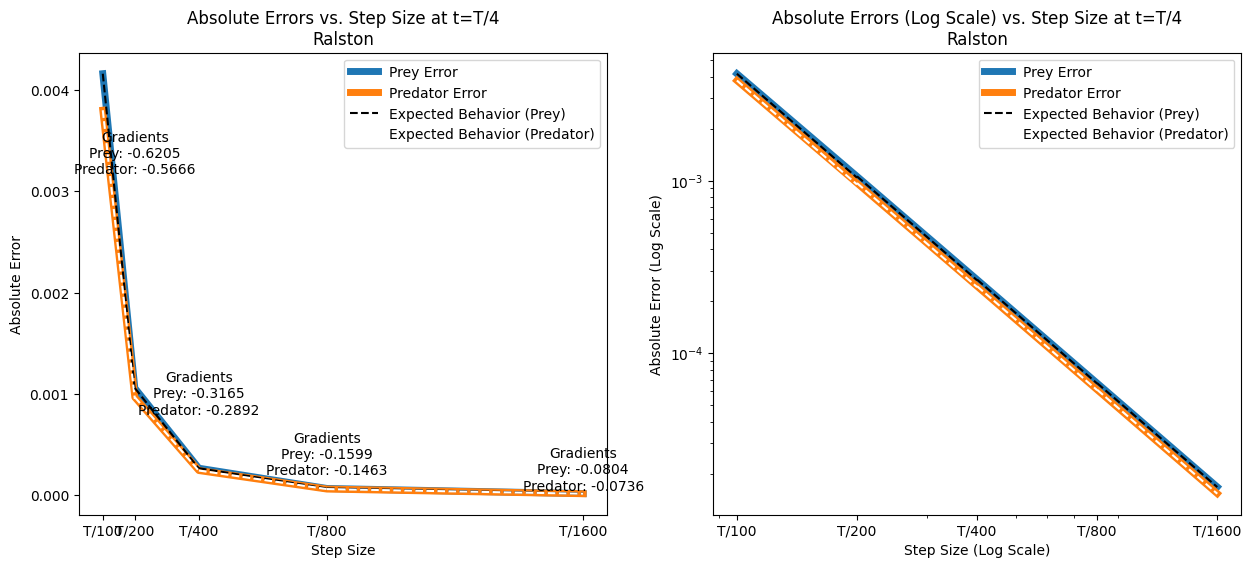

Table for Method: Runge-Kutta
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|   Step Size |   Error (Prey) at t=T/4 |   Error (Predator) at t=T/4 | Ratio of Previous Error (Prey, Predator)   |
+=============+=========================+=============================+============================================+
|         100 |             4.23407e-06 |                 3.42458e-06 | (nan, nan)                                 |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         200 |             2.69611e-07 |                 2.19733e-07 | (0.0636766626664506, 0.06416344954165794)  |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         400 |             1.70084e-08 |                 1.39125e-08 | (0.06308501166268964, 0.06331560217405655) |
+-------------+-------------------

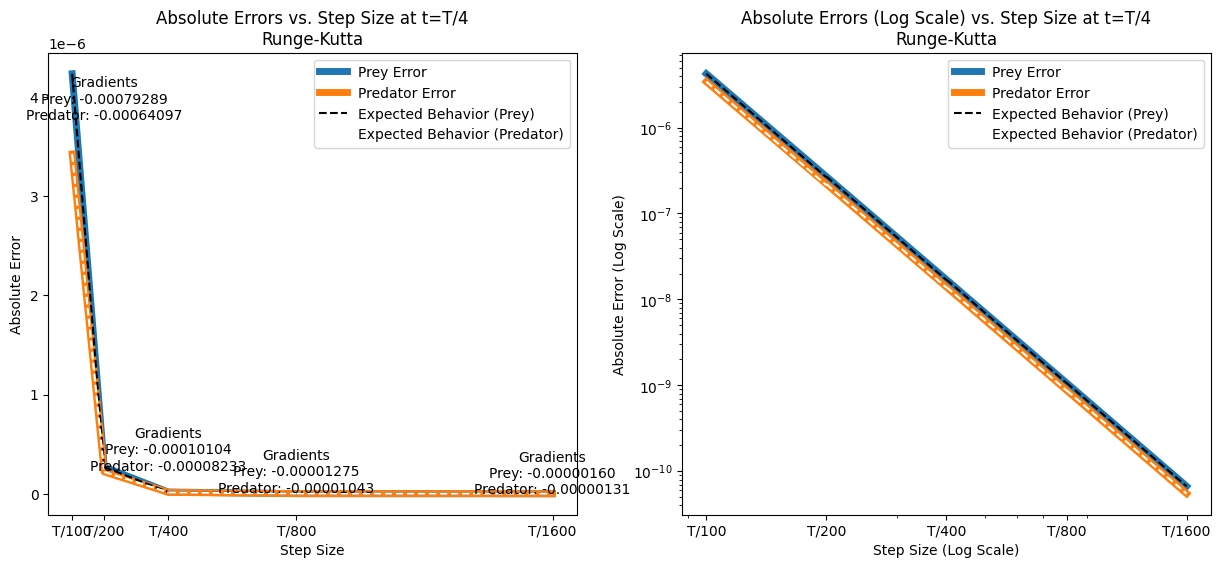

Table for Method: Midpoint
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|   Step Size |   Error (Prey) at t=T/4 |   Error (Predator) at t=T/4 | Ratio of Previous Error (Prey, Predator)   |
+=============+=========================+=============================+============================================+
|         100 |             0.00732936  |                 0.00571974  | (nan, nan)                                 |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         200 |             0.0018776   |                 0.00147045  | (0.2561752898607631, 0.2570836279591542)   |
+-------------+-------------------------+-----------------------------+--------------------------------------------+
|         400 |             0.000475368 |                 0.00037314  | (0.25317836990167814, 0.25375890330264905) |
+-------------+----------------------

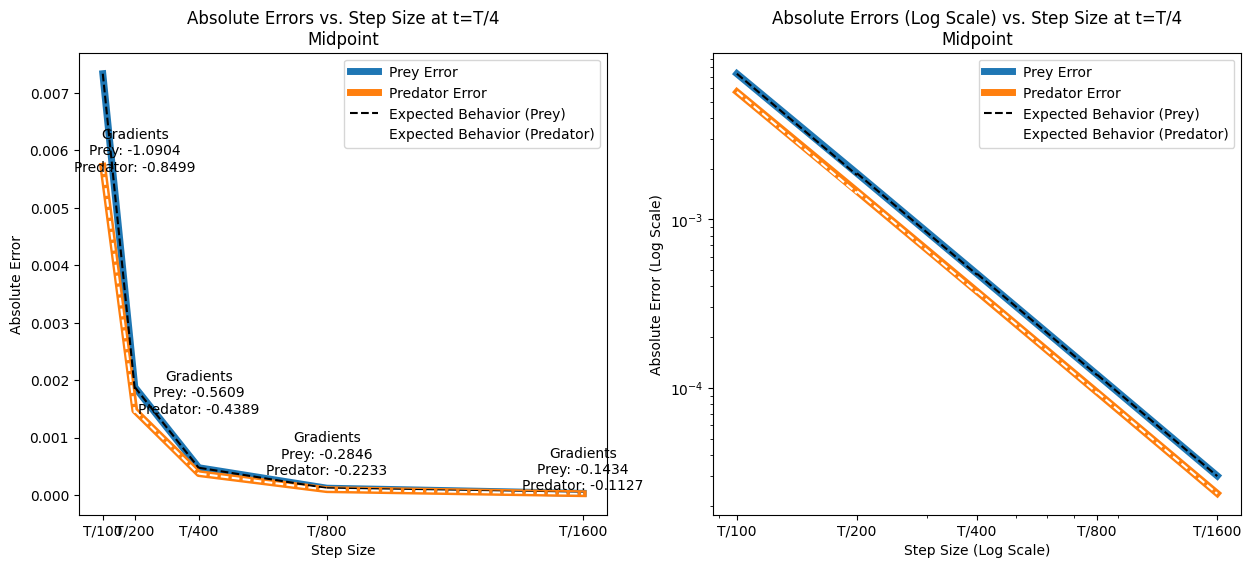

In [18]:
def calculate_absolute_error_at_t(method, steps):
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / steps, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / steps, T_A, method)

    sol = np.array(sol)

    t_exact_A = np.linspace(0, T_A, num=len(t))
    x_exact_A = 1 + np.cos(t_exact_A)
    y_exact_A = 1 - np.cos(t_exact_A)

    index_t2 = round(0.25 * steps)

    error_x_t2 = abs(x_exact_A[index_t2] - sol[index_t2, 0])
    error_y_t2 = abs(y_exact_A[index_t2] - sol[index_t2, 1])

    return error_x_t2, error_y_t2

for method in methods:
    prey_errors = []
    predator_errors = []
    method_results = []
    
    for i, steps in enumerate(time_steps):
        error_x_t2, error_y_t2 = calculate_absolute_error_at_t(method, steps)
        if i > 0:
            previous_error_x_t2 = method_results[-1][1]
            previous_error_y_t2 = method_results[-1][2]

            ratio_x = error_x_t2 / previous_error_x_t2
            ratio_y = error_y_t2 / previous_error_y_t2 
        else:
            ratio_x = np.nan
            ratio_y = np.nan

        method_results.append([steps, error_x_t2, error_y_t2, (ratio_x, ratio_y)])
        prey_errors.append(error_x_t2)
        predator_errors.append(error_y_t2)

    headers = ["Step Size", "Error (Prey) at t=T/4", "Error (Predator) at t=T/4", "Ratio of Previous Error (Prey, Predator)"]
    table = tabulate(method_results, headers, tablefmt="grid", showindex=False)

    print(f"Table for Method: {method}")
    print(table)
    print()
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].plot(time_steps, prey_errors, linewidth=5, label="Prey Error")
    axs[0].plot(time_steps, predator_errors, linewidth=5, label="Predator Error")

    for i in range(1, len(time_steps)):
        expected_x = [time_steps[i-1], time_steps[i]]
        expected_y_prey = [prey_errors[i-1], prey_errors[i-1] / 4]  
        expected_y_predator = [predator_errors[i-1], predator_errors[i-1] / 4] 

        if method == "Runge-Kutta":
            expected_y_prey[1] = prey_errors[i-1] / 16  # the exact solution for runge-kutta is fourth order
            expected_y_predator[1] = predator_errors[i-1] / 16 

        axs[0].plot(expected_x, expected_y_prey, linestyle='--', color='black')
        axs[0].plot(expected_x, expected_y_predator, linestyle='--', color='white')

    for i in range(1, len(time_steps)):
        gradient_x = (prey_errors[i] - prey_errors[i-1]) / ((1/time_steps[i]) - (1/time_steps[i-1]))
        gradient_y = (predator_errors[i] - predator_errors[i-1]) / ((1/time_steps[i]) - (1/time_steps[i-1]))

        if method=="Runge-Kutta":
            axs[0].annotate(
            f"Gradients\nPrey: -{gradient_x:.8f}\nPredator: -{gradient_y:.8f}",
            xy=(time_steps[i], prey_errors[i]),
            xytext=(time_steps[i], prey_errors[i] * 14),
            ha='center'
        )
        else:
            axs[0].annotate(
                f"Gradients\nPrey: -{gradient_x:.4f}\nPredator: -{gradient_y:.4f}",
                xy=(time_steps[i], prey_errors[i]),
                xytext=(time_steps[i], prey_errors[i] * 3),
                ha='center'
            )
    axs[0].legend(["Prey Error", "Predator Error", "Expected Behavior (Prey)", "Expected Behavior (Predator)"])
    axs[0].set_title(f"Absolute Errors vs. Step Size at t=T/4\n{method}")
    axs[0].set_xlabel("Step Size")
    axs[0].set_xticks(time_steps)
    axs[0].set_xticklabels([f'T/{step}' for step in time_steps])
    axs[0].set_ylabel("Absolute Error")
    axs[1].plot(time_steps, prey_errors, linewidth=5, label="Prey Error")
    axs[1].plot(time_steps, predator_errors, linewidth=5, label="Predator Error")
    for i in range(1, len(time_steps)):
        expected_x = [time_steps[i-1], time_steps[i]]
        expected_y_prey = [prey_errors[i-1], prey_errors[i-1] / 4]  
        expected_y_predator = [predator_errors[i-1], predator_errors[i-1] / 4] 
        if method == "Runge-Kutta":
            expected_y_prey[1] = prey_errors[i-1] / 16
            expected_y_predator[1] = predator_errors[i-1] / 16 
        axs[1].plot(expected_x, expected_y_prey, linestyle='--', color='black')
        axs[1].plot(expected_x, expected_y_predator, linestyle='--', color='white')
    # log setup
    axs[1].legend(["Prey Error", "Predator Error", "Expected Behavior (Prey)", "Expected Behavior (Predator)"])
    axs[1].set_title(f"Absolute Errors (Log Scale) vs. Step Size at t=T/4\n{method}")
    axs[1].set_xlabel("Step Size (Log Scale)")
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xticks(time_steps)
    axs[1].set_xticklabels([f'T/{step}' for step in time_steps])
    axs[1].set_ylabel("Absolute Error (Log Scale)")
    plt.show()


### Test Case B Inaccuracies
For Test Case B, we don't have an exact solution to measure against, however using the information that the solution should repeat itself and the maxima of each population shouldn't change, we can compare the values of the turning points to see if there is any error.

#### Plotting Maxima Gradients using Turning Points

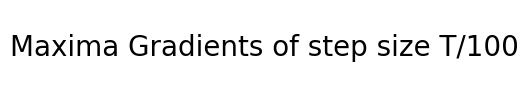

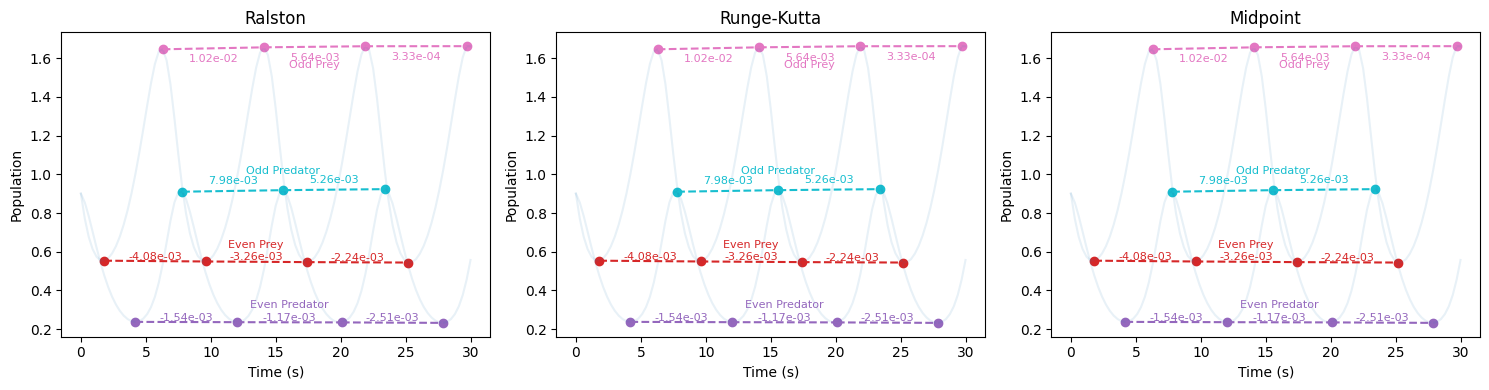

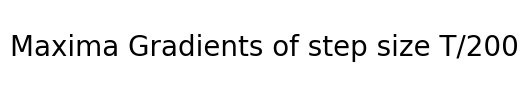

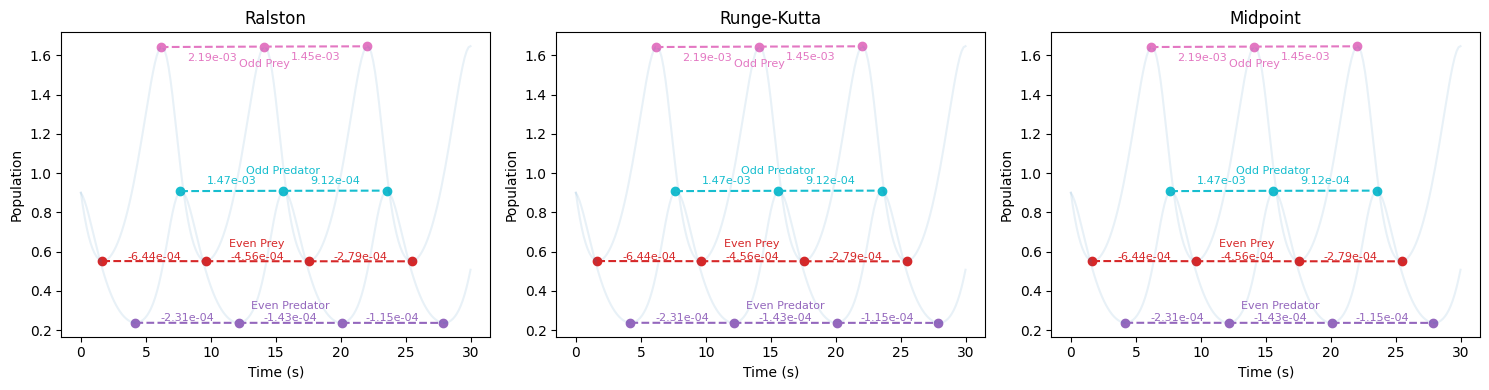

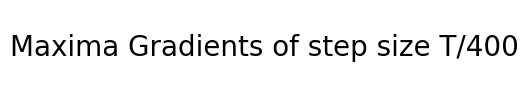

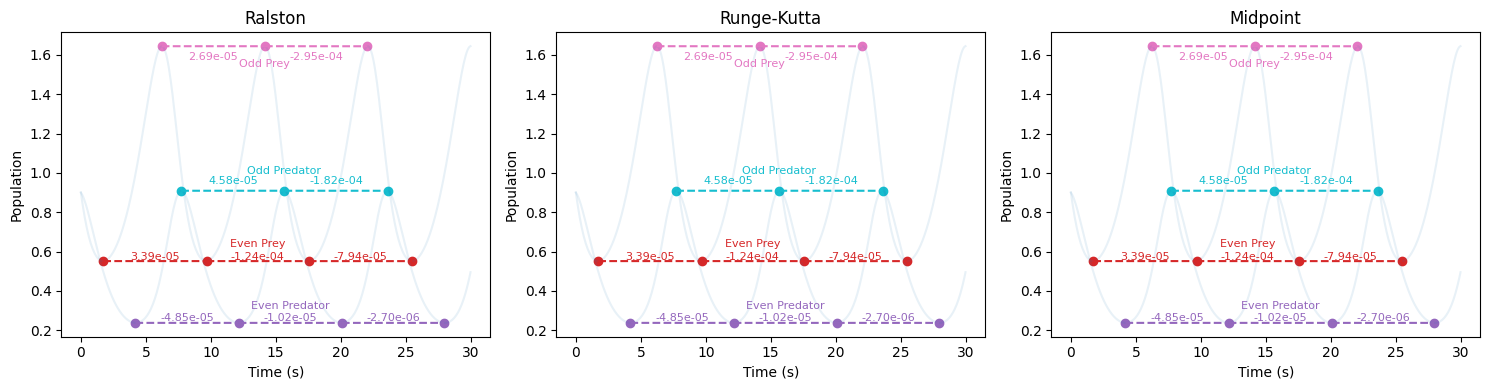

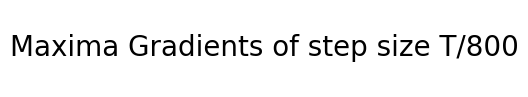

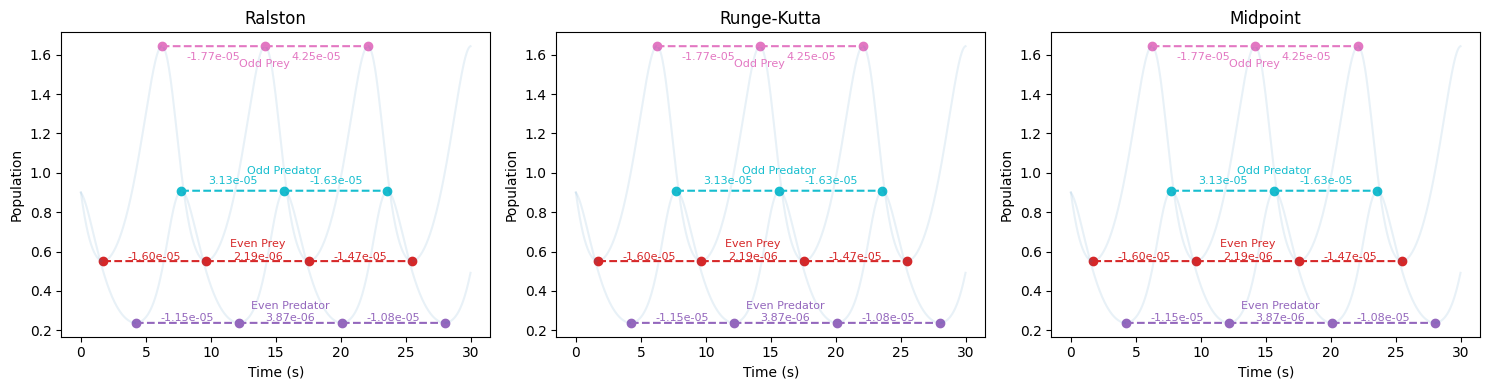

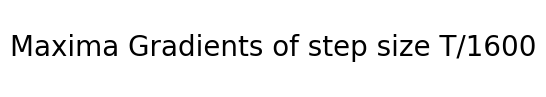

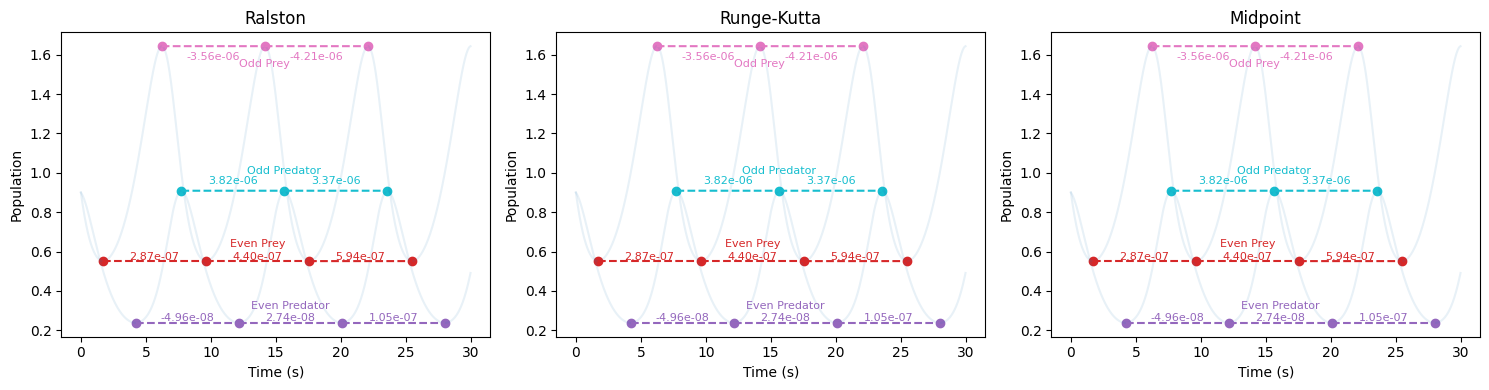

In [12]:
for steps in time_steps:
    plt.figure(figsize=(3, 1))
    plt.axis('off')
    section_text = "Maxima Gradients of step size T/" + str(steps)
    plt.text(0.5, 0.5, section_text, horizontalalignment='center', verticalalignment='center', fontsize=20)
    plt.show()
    for idx, method in enumerate(methods, 1):
        if method == "Midpoint":
            t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / steps, T_B)
        else:
            t, sol = solver(rhs_B, u0_B, 0, T_B / steps, T_B, method)
        sol = np.array(sol)

        turning_points_x = []
        turning_points_xt = []
        for i in range(1, len(sol) - 1):
            if (sol[i, 0] - sol[i - 1, 0]) * (sol[i + 1, 0] - sol[i, 0]) < 0: # turning point
                turning_points_x.append(sol[i, 0])
                turning_points_xt.append(t[i])

        #repeats for y
        turning_points_y = []
        turning_points_yt = []
        for i in range(1, len(sol) - 1):
            if (sol[i, 1] - sol[i - 1, 1]) * (sol[i + 1, 1] - sol[i, 1]) < 0:
                turning_points_y.append(sol[i, 1])
                turning_points_yt.append(t[i])
    plt.figure(figsize=(15, 4))
    trajectory_color = '#1f77b4'  # blue
    turning_point_color_x = '#ff7f0e'  # orange
    turning_point_color_y = '#2ca02c'  # green
    line_color_even_x = '#d62728'  # red
    line_color_odd_x = '#e377c2'  # pink
    line_color_even_y = '#9467bd'  # purple
    line_color_odd_y = '#17becf'  # cyan

    for idx, method in enumerate(methods, 1):
        plt.subplot(1, 3, idx)
        plt.plot(t, sol[:, 0], color=trajectory_color, alpha=0.1)
        plt.plot(t, sol[:, 1], color=trajectory_color, alpha=0.1)
        # plotting the turning points
        for i, (xt, x) in enumerate(zip(turning_points_xt, turning_points_x)):
            color_x = line_color_even_x if i % 2 == 0 else line_color_odd_x
            plt.scatter(xt, x, color=color_x, marker='o')
        for i, (yt, y) in enumerate(zip(turning_points_yt, turning_points_y)):
            color_y = line_color_even_y if i % 2 == 0 else line_color_odd_y
            plt.scatter(yt, y, color=color_y, marker='o')

            # repeating this for each set of turning points to draw lines between them
        for i in range(0, len(turning_points_x) - 2, 2):
            x_values = [turning_points_x[i], turning_points_x[i + 2]]
            t_values = [turning_points_xt[i], turning_points_xt[i + 2]]
            plt.plot(t_values, x_values, linestyle='--', color=line_color_even_x)
            plt.annotate(f'{x_values[1] - x_values[0]:.2e}', (np.mean(t_values), np.mean(x_values)),
                        textcoords="offset points", xytext=(0, 1), ha='center', fontsize=8, color=line_color_even_x)

        for i in range(0, len(turning_points_y) - 2, 2):
            y_values = [turning_points_y[i], turning_points_y[i + 2]]
            t_values = [turning_points_yt[i], turning_points_yt[i + 2]]
            plt.plot(t_values, y_values, linestyle='--', color=line_color_even_y)
            plt.annotate(f'{y_values[1] - y_values[0]:.2e}', (np.mean(t_values), np.mean(y_values)),
                        textcoords="offset points", xytext=(0, 1), ha='center', fontsize=8, color=line_color_even_y)

        for i in range(1, len(turning_points_x) - 2, 2):
            x_values = [turning_points_x[i], turning_points_x[i + 2]]
            t_values = [turning_points_xt[i], turning_points_xt[i + 2]]
            plt.plot(t_values, x_values, linestyle='--', color=line_color_odd_x)
            plt.annotate(f'{x_values[1] - x_values[0]:.2e}', (np.mean(t_values), np.mean(x_values)),
                        textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8, color=line_color_odd_x)

        for i in range(1, len(turning_points_y) - 2, 2):
            y_values = [turning_points_y[i], turning_points_y[i + 2]]
            t_values = [turning_points_yt[i], turning_points_yt[i + 2]]
            plt.plot(t_values, y_values, linestyle='--', color=line_color_odd_y)
            plt.annotate(f'{y_values[1] - y_values[0]:.2e}', (np.mean(t_values), np.mean(y_values)),
                        textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color=line_color_odd_y)

        # label each line drawn with even x, odd x, even y, and odd y turning point lines
        plt.annotate('Even Prey', (np.mean(turning_points_xt[::2]), np.mean(turning_points_x[::2])),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color=line_color_even_x)
        plt.annotate('Odd Prey', (np.mean(turning_points_xt[1::2]), np.mean(turning_points_x[1::2])),
                    textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8, color=line_color_odd_x)
        plt.annotate('Even Predator', (np.mean(turning_points_yt[::2]), np.mean(turning_points_y[::2])),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color=line_color_even_y)
        plt.annotate('Odd Predator', (np.mean(turning_points_yt[1::2]), np.mean(turning_points_y[1::2])),
                    textcoords="offset points", xytext=(0, 12), ha='center', fontsize=8, color=line_color_odd_y)

        plt.title(f"{method}")
        plt.xlabel("Time (s)")
        plt.ylabel("Population")

    plt.tight_layout()
    plt.show()

                

Reducing the step size decreases the difference in maxima, but this difference is constant across all methods, suggesting it is simply a machine precision issue.

#### Maxima Gradients - Closer Look

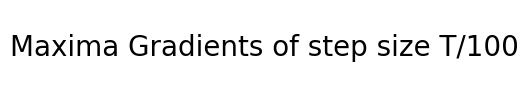

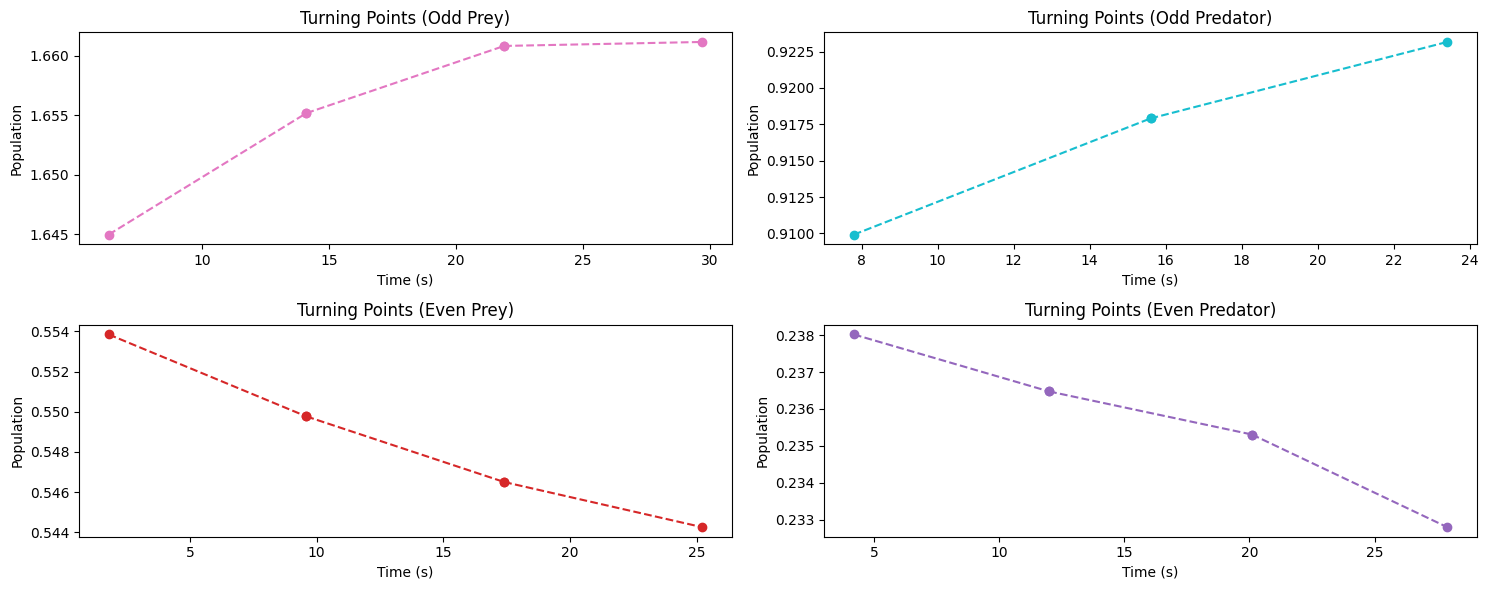

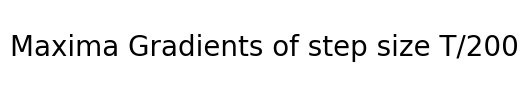

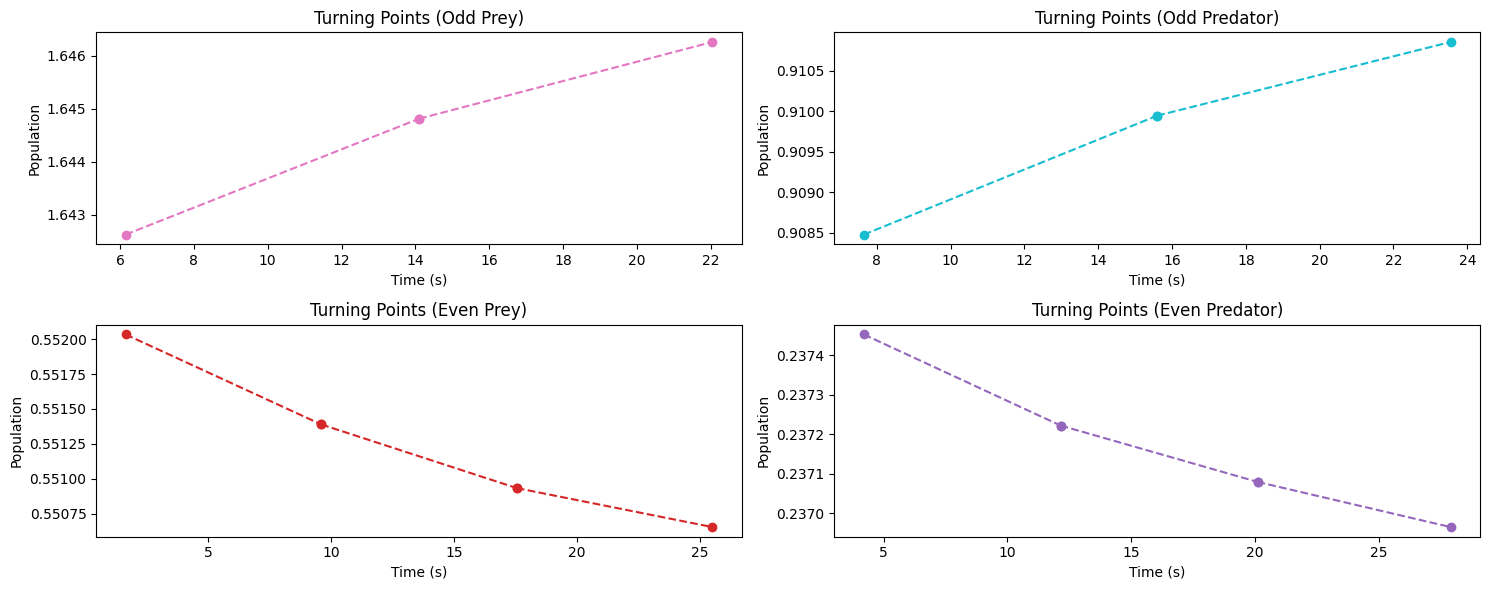

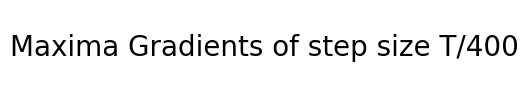

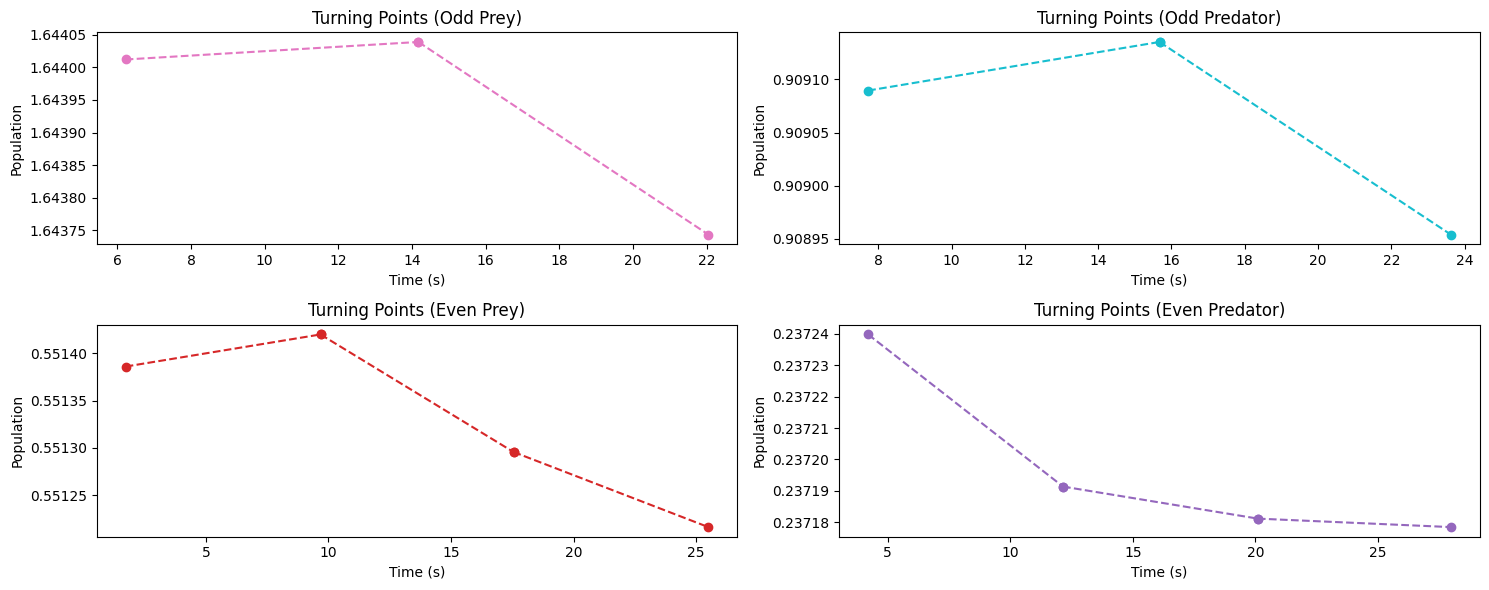

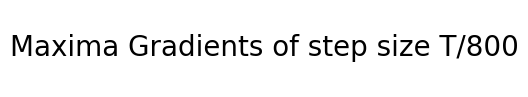

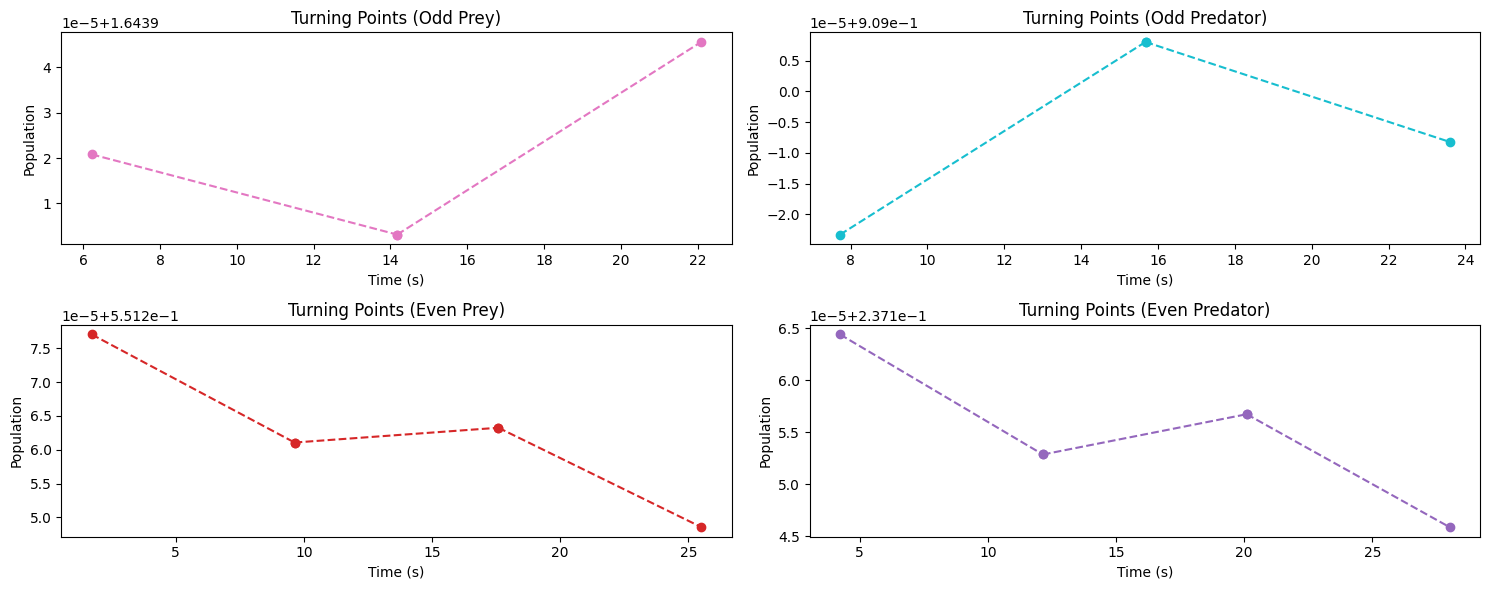

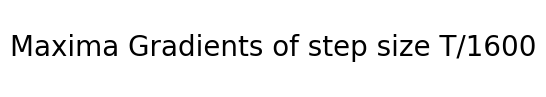

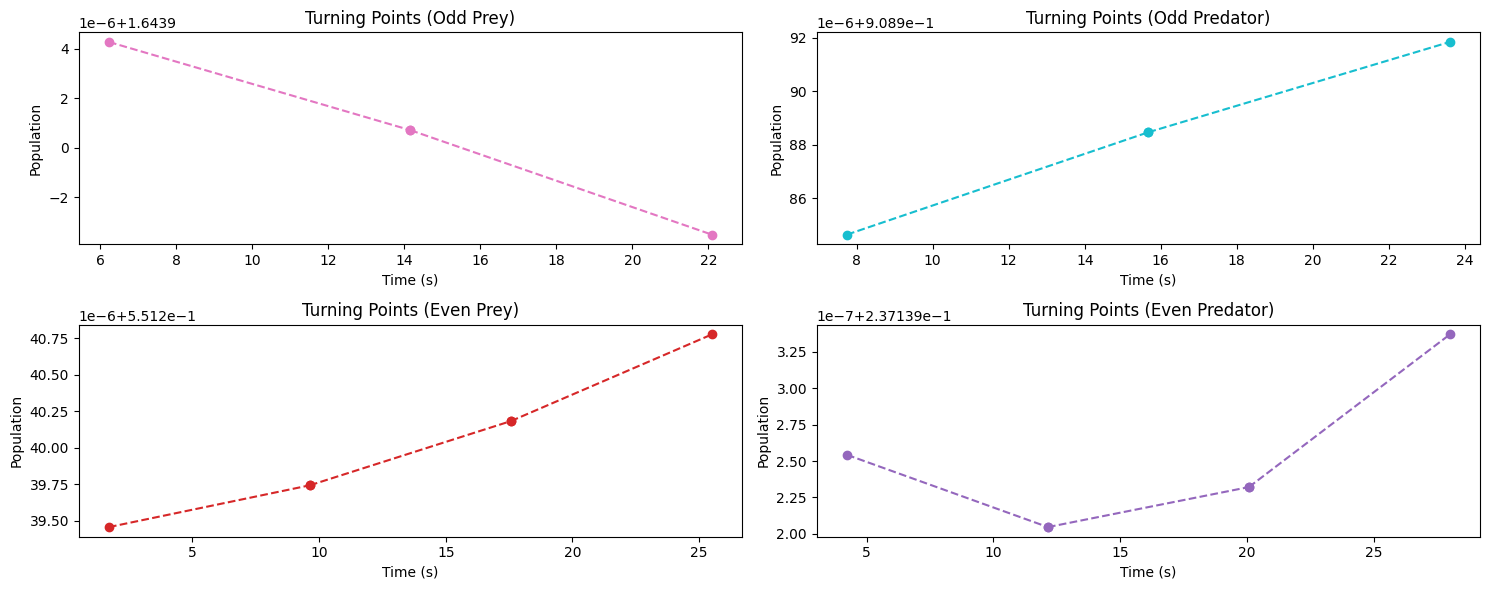

In [13]:
# same as previous setup but splits the lines up to seperate graph and no reference solution
for steps in time_steps:
    plt.figure(figsize=(3, 1))
    plt.axis('off')
    section_text = "Maxima Gradients of step size T/" + str(steps)
    plt.text(0.5, 0.5, section_text, horizontalalignment='center', verticalalignment='center', fontsize=20)
    plt.show()
    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / steps, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / steps, T_B, method)
    sol = np.array(sol)

    turning_points_x = []
    turning_points_xt = []
    for i in range(1, len(sol) - 1):
        if (sol[i, 0] - sol[i - 1, 0]) * (sol[i + 1, 0] - sol[i, 0]) < 0:
            turning_points_x.append(sol[i, 0])
            turning_points_xt.append(t[i])

    turning_points_y = []
    turning_points_yt = []
    for i in range(1, len(sol) - 1):
        if (sol[i, 1] - sol[i - 1, 1]) * (sol[i + 1, 1] - sol[i, 1]) < 0:
            turning_points_y.append(sol[i, 1])
            turning_points_yt.append(t[i])

    plt.figure(figsize=(15, 6))
    for line_type in ['odd_prey', 'odd_predator', 'even_prey', 'even_predator']:
        plt.subplot(2, 2, {'odd_prey': 1, 'odd_predator': 2, 'even_prey': 3, 'even_predator': 4}[line_type])
        if 'prey' in line_type:
            values = turning_points_x
            time_values = turning_points_xt
            color = line_color_odd_x if 'odd' in line_type else line_color_even_x
        else:
            values = turning_points_y
            time_values = turning_points_yt
            color = line_color_odd_y if 'odd' in line_type else line_color_even_y

        for i in range(1 if 'odd' in line_type else 0, len(values) - 2, 2):
            y_values = [values[i], values[i + 2]]
            t_values = [time_values[i], time_values[i + 2]]
            plt.plot(t_values, y_values, color=color, linestyle="--", marker="o")

        plt.title(f"Turning Points ({line_type.replace('_', ' ').title()})")
        plt.xlabel("Time (s)")
        plt.ylabel("Population")

    plt.tight_layout()
    plt.show()


## Analysis

[*Comment on the efficiency and accuracy of each approach. [250 words]*]

#### __Efficiency - Calculation Time__
For all 3 methods, the calculation time compared to step size is roughly inversely proportional.

*Note $s/it$ implies seconds per iteration:*
For all methods, calculating case $B$ was faster than calculating case $A$. Consistently, Runge-Kutta is the slowest compute of all methods ($~5 \times 10 ^ -5  s/it$ for $A$, $~3.2 \times 10 ^ -5  s/it$ for $B$), and Midpoint is the fastest ($~1.4 \times 10 ^ -5  s/ it$ for $A$, $~7 \times 10 ^ -6  s/ it$ for $B$), with Ralston performing marginally slower ($~2 \times 10 ^ -5  s/ it$ for $A$, $~1.5 \times 10 ^ -5  s/ it$ for $B$).

#### __Accuracy - Solution Inaccuracy for Test Case A__
Visually, only at as we approach T do the plotted methods begin to diverge from the exact solution. Inspecting each method on a closer scale, Ralston and Midpoint share similar average error before the final spike - but as the interval decreases, the average error of Ralston decreases faster than Midpoint.The anomalous spike is consistently around $3\times$ smaller using Ralston instead of Midpoint. Runge-Kutta consistently produced results at least $2$ orders of magnitude more accurate than the other two methods, up to a difference of $10^5$ at the smallest intervals, with an average error of $~1\times10^{-10}$.

I have taken the arbitrary point $0.25T = 5\pi/8 $, and its' absolute error. Then, I have plotted how this error changes compared to the interval size. We can see that for the Ralston and Midpoint methods, the absolute error approximately quarters each time the interval halves. Likewise, the Runge-Kutta method divides by 16 each time the interval halves. I included a reference line displaying the exact behaviour described above. The error lines follow this behaviour almost exactly, and become linear when plotted logarithmically.
For Ralston and Midpoint, the error $(E)$ can be attributed to a second order method:

$$ E = k \cdot (\text{{interval size}})^2 $$

Similarly, for Runge-Kutta, the error is defined by the quartic relationship of a fourth order method:

$$ E = k \cdot (\text{{interval size}})^4 $$

#### __Accuracy - Solution Inaccuracy for Test Case B__
Since we are given no exact solution, for this case I have based the accuracy around the maxima of the populations, which we know should repeat itself and not change over time. 
I sort the turning points by even and odd for each population, as after 2 turning points, the system should repeat. Any gradient between points in each maxima group implies some absolute error.

My results from this experiment suggest that although there is some absolute error in the maxima, each method produces the same result, dependent only on step size.Halving the step size consistently divides the error by a factor of $5$.

 I have provided graphs that show only the turning points plotted on a smaller scale. We can see from this that at larger step sizes, the Maximas diverge from the initial point, such that the peaks become higher and valleys become lower.
As the step size decreases, the change in maxima does decrease, but this divergence is no longer consistently seen. Instead, some plots, such as *"Turning Points for Even Predators - $T/1600$ Step Size"* show multiple turning points.

I have not been able to explore this fully, but I will suggest that this behaviour is likely because the maxima of Test Case B do not lie on a point that is divisible by the step size $T/1600$ (and as such all larger step sizes that contain this as a factor). Therefore, for each repetition of the solution, the difference between the true maxima and our closest factor of the step size changes. If this is the case, then the turning points of absolute error imply that the polarity of the difference to our true maxima has changed. 

Since there is no visible difference between methods, I do not think it is significant enough to explore this further.

## Conclusion

[*Compare the methods that you have results for, and any other relevant methods from the module, and make a recommendation of which method you think is best. [300 words]*]

#### __Overall Results__
#### Efficiency
1. Midpoint
2. Ralston
3. Runge-Kutta


Midpoint is the most efficient by a significant margin, considering 2 key factors:
- It takes the least amount of time to compute for both test cases.
- It has the shallowest compute time gradient, so will scale better than any other method


In order for Midpoint to use the same compute time as Runge-Kutta at $T/1600$ interval, we could run it at even smaller than a $T/3200$ interval! (estimated by extrapolating compute gradient)
#### Accuracy
1. Runge-Kutta
2. Ralston
3. Midpoint

Runge-Kutta is likewise, most accurate significantly. This is because its' absolute error shares a quartic relationship with the interval size, compared to the quadratic relationship shared by Ralston and Midpoint. Even at the largest interval of $T/100$, the accuracy is magnitudes greater than the other 2 methods.


#### __Conclusion__

#### Test Case A
In conclusion, the most appropriate method for Test Case A, considering accuracy and efficiency, at the smallest time interval, must be __Runge-Kutta__. The accuracy at any interval size is far greater than the other 2 methods, and since the compute time complexity is only linear: $O(t)$ compared to the accuracy of $k\cdot {dt}^4$, the efficiency is not enough of a detriment to invalidate the results this method produces.

*Alternatively, if compute time was instead a major priority (for example in a low performance system), I would suggest the __Midpoint__ method. At larger intervals, it's accuracy is comparable to Ralston (even at a marginal tolerance), while being significantly more efficient.*

#### Test Case B
For Test Case B, the accuracy of the solution is independent of the method chosen. Therefore, we should only prioritise efficiency with the greatest step size, which is of course __Midpoint__, which has the slowest compute growth rate of all these methods.
